In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/opt

In [2]:
l1 = sc.read_h5ad(
    filename="/home/sources/samples/L1/L1_L00_filtered.h5ad"
)
l2 = sc.read_h5ad(
    filename="/home/sources/samples/L2/L2_L00_filtered.h5ad"
)

# Check QC

In [3]:
# mitochondrial genes
l1.var["mt"] = l1.var_names.str.startswith("MT-")
l2.var["mt"] = l2.var_names.str.startswith("MT-")

# ribosomal genes
l1.var["ribo"] = l1.var_names.str.startswith(("RPS", "RPL"))
l2.var["ribo"] = l2.var_names.str.startswith(("RPS", "RPL"))


sc.pp.calculate_qc_metrics(
    l1, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
sc.pp.calculate_qc_metrics(
    l2, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
l1

AnnData object with n_obs × n_vars = 4422 × 68066
    obs: 'n_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

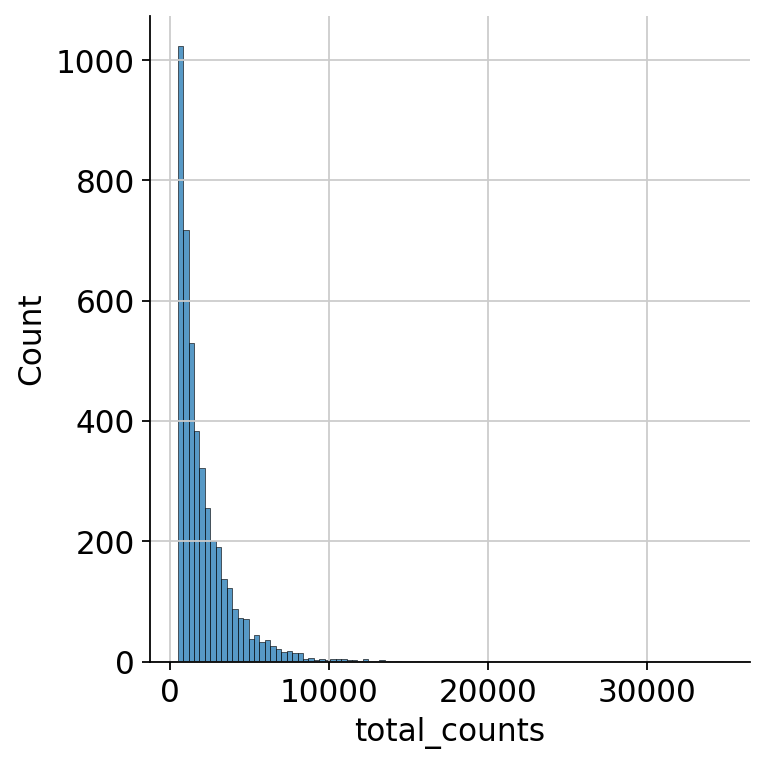

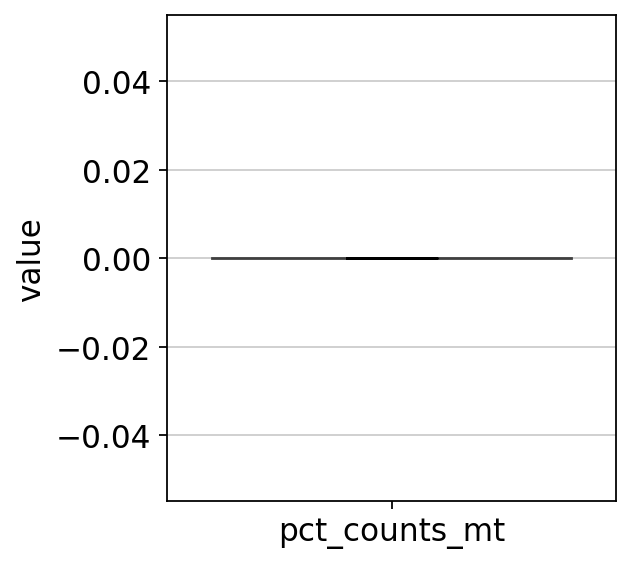

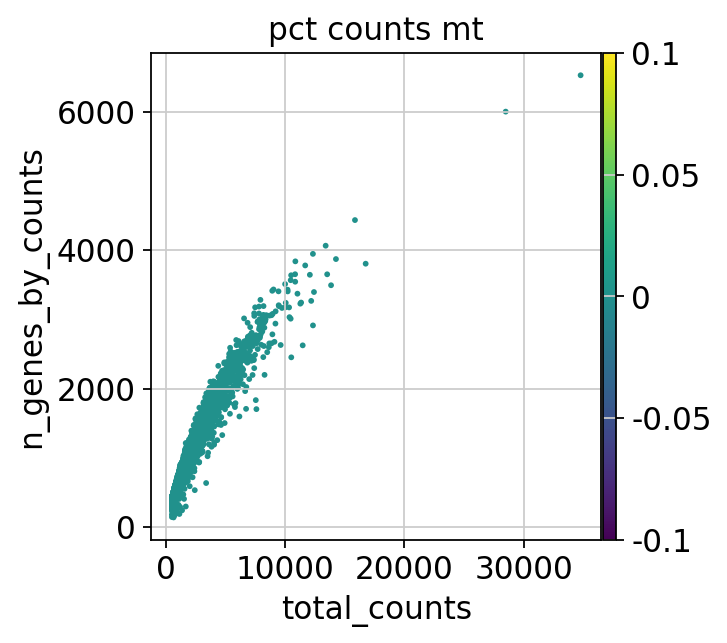

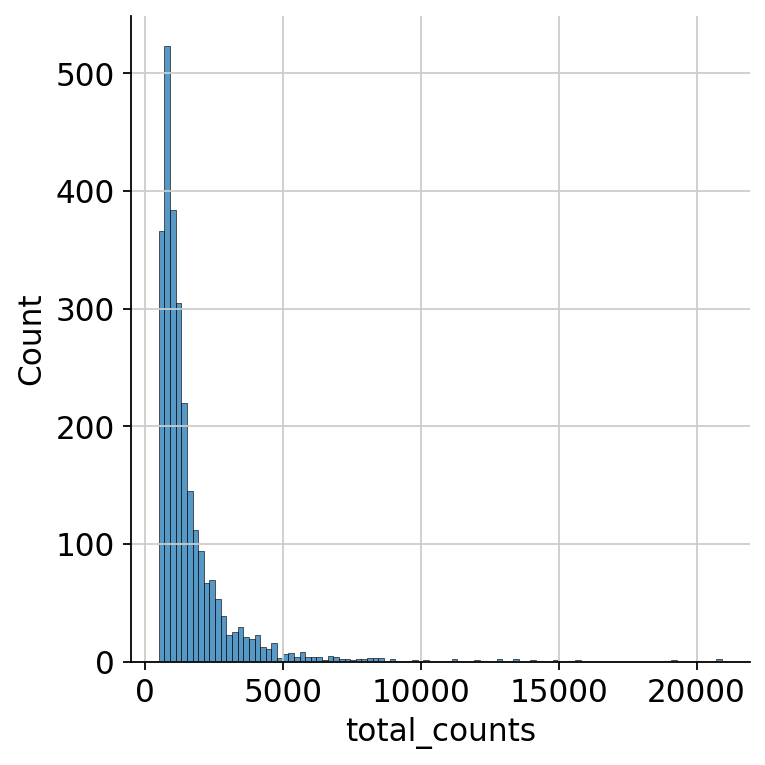

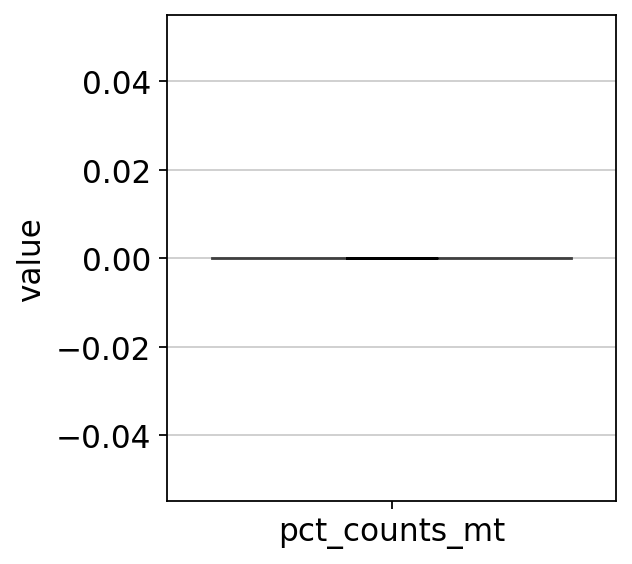

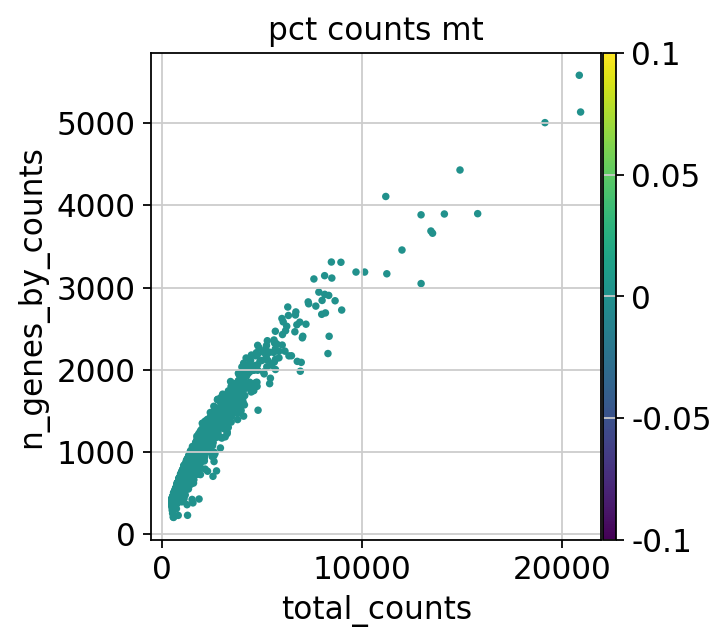

In [4]:
p1 = sns.displot(l1.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(l1, "pct_counts_mt")
p3 = sc.pl.scatter(l1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p4 = sns.displot(l2.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p5 = sc.pl.violin(l2, "pct_counts_mt")
p6 = sc.pl.scatter(l2, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Ambient RNA

In [3]:
import anndata2ri
import logging
import os

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [6]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [7]:
l1_raw = sc.read_10x_mtx(
    path="/home/sources/samples/L1/raw_cell_gene_matrix"
)
l1_tod = l1_raw.X.T
l2_raw = sc.read_10x_mtx(
    path="/home/sources/samples/L2/raw_cell_gene_matrix"
)
l2_tod = l2_raw.X.T

In [8]:
del l1_raw
del l2_raw

In [9]:
l1_pp = l1.copy()
sc.pp.normalize_per_cell(l1_pp)
sc.pp.log1p(l1_pp)
l2_pp = l2.copy()
sc.pp.normalize_per_cell(l2_pp)
sc.pp.log1p(l2_pp)

In [10]:
sc.pp.pca(l1_pp)
sc.pp.neighbors(l1_pp)
sc.tl.leiden(l1_pp, key_added="soupx_groups")
sc.pp.pca(l2_pp)
sc.pp.neighbors(l2_pp)
sc.tl.leiden(l2_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups_l1 = l1_pp.obs["soupx_groups"]
soupx_groups_l2 = l2_pp.obs["soupx_groups"]

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_168463/2418096638.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(l1_pp, key_added="soupx_groups")


In [11]:
del l1_pp
del l2_pp

In [12]:
cells_l1 = l1.obs_names
genes_l1 = l1.var_names
data_l1 = l1.X.T
cells_l2 = l2.obs_names
genes_l2 = l2.var_names
data_l2 = l2.X.T

In [13]:
%%R -i data_l1 -i l1_tod -i genes_l1 -i cells_l1 -i soupx_groups_l1 -o out_l1 

# specify row and column names of data
rownames(data_l1) = genes_l1
colnames(data_l1) = cells_l1
# ensure correct sparse format for table of counts and table of droplets
data_l1 <- as(data_l1, "sparseMatrix")
l1_tod <- as(l1_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(l1_tod, data_l1, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data_l1), est = rowSums(data_l1)/sum(data_l1), counts = rowSums(data_l1))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups_l1)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out_l1 = adjustCounts(sc, roundToInt = TRUE)

In [14]:
%%R -i data_l2 -i l2_tod -i genes_l2 -i cells_l2 -i soupx_groups_l2 -o out_l2 

# specify row and column names of data
rownames(data_l2) = genes_l2
colnames(data_l2) = cells_l2
# ensure correct sparse format for table of counts and table of droplets
data_l2 <- as(data_l2, "sparseMatrix")
l2_tod <- as(l2_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(l2_tod, data_l2, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data_l2), est = rowSums(data_l2)/sum(data_l2), counts = rowSums(data_l2))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups_l2)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out_l2 = adjustCounts(sc, roundToInt = TRUE)

In [15]:
l1.layers["counts"] = l1.X
l1.layers["soupX_counts"] = out_l1.T
l1.X = l1.layers["soupX_counts"]
l2.layers["counts"] = l2.X
l2.layers["soupX_counts"] = out_l2.T
l2.X = l2.layers["soupX_counts"]

In [16]:
print(f"Total number of genes: {l1.n_vars}")

# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(l1, min_cells=3)
print(f"Number of genes after cell filter: {l1.n_vars}")

Total number of genes: 68066
Number of genes after cell filter: 16463


In [17]:
print(f"Total number of genes: {l2.n_vars}")

# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(l2, min_cells=3)
print(f"Number of genes after cell filter: {l2.n_vars}")

Total number of genes: 68066
Number of genes after cell filter: 15858


In [ ]:
#l1.write_h5ad('/home/sources/L1_preprocessed.h5ad')
#l2.write_h5ad('/home/sources/L2_preprocessed.h5ad')

# Doublets

In [4]:
l1 = sc.read_h5ad(
    filename="/home/sources/L1_preprocessed.h5ad"
)
l2 = sc.read_h5ad(
    filename="/home/sources/L2_preprocessed.h5ad"
)

In [7]:
%%R
BiocManager::install("scDblFinder")

* installing *source* package ‘Cairo’ ...
** package ‘Cairo’ successfully unpacked and MD5 sums checked
** using staged installation


checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to enable C11 features... none needed
checking for sys/wait.h that is POSIX.1 compatible... yes
checking for stdio.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for inttypes.h... yes
checking for stdint.h... yes
checking for strings.h... yes
checking for sys/stat.h... yes
checking for sys/types.h... yes
checking for unistd.h... yes
checking for string.h... (cached) yes
checking for sys/time.h... yes
checking for unistd.h... (cached) yes
checking for an ANSI C-conforming const... yes
checking for pkg-config... /usr/bin/pkg-config
c

configure: error: Cannot find cairo.h! Please install cairo (http://www.cairographics.org/) and/or set CAIRO_CFLAGS/LIBS correspondingly.
ERROR: configuration failed for package ‘Cairo’
* removing ‘/opt/conda/lib/R/library/Cairo’
* installing *source* package ‘ragg’ ...
** package ‘ragg’ successfully unpacked and MD5 sums checked
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu 
Using PKG_LIBS=-lfreetype -lpng16 -ltiff -ljpeg 
-----------------------------[ ANTICONF ]-------------------------------
Configuration failed to find one of freetype2 libpng libtiff-4 libjpeg. Try installing:
 * deb: libfreetype6-dev libpng-dev libtiff5-dev libjpeg-dev (Debian, Ubuntu, etc)
 * rpm: freetype-devel libpng-devel libtiff-devel libjpeg-devel (Fedora, CentOS, RHEL)
 * csw: libfreetype_dev libpng16_dev libtiff_dev libjpeg_dev (Solaris)
If freetype2 libpng libtiff-4 libjpeg is already installed, check that 'pkg-config' is in your
PATH and PKG_CONFIG_PATH contains a freetype2 libpng libtiff-4 libjpeg.pc file. If pkg-config
is unavailable you can set INCLUDE_DIR and LIB_DIR manually via:
R CMD INSTALL --configure-vars='INCLUDE_DIR=... LIB_DIR=...'
-------------------------- [ERROR MESSAGE] ---------------------------
In file included from /opt/con

ERROR: configuration failed for package ‘ragg’
* removing ‘/opt/conda/lib/R/library/ragg’
* installing *source* package ‘ggbeeswarm’ ...
** package ‘ggbeeswarm’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggbeeswarm)
* installing *source* package ‘restfulr’ ...
** package ‘restfulr’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 14.2.0-1) 14.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c init.c -o init.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3

installing to /opt/conda/lib/R/library/00LOCK-restfulr/00new/restfulr/libs
** R
** inst
** byte-compile and prepare package for lazy loading


Creating a new generic function for ‘assign’ in package ‘restfulr’


** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (restfulr)
ERROR: failed to lock directory ‘/opt/conda/lib/R/library’ for modifying
Try removing ‘/opt/conda/lib/R/library/00LOCK-xgboost’
* installing *source* package ‘Rsamtools’ ...
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 14.2.0-1) 14.2.0’
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 14.2.0-1) 14.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -I'/opt/conda/lib/R/library/Biostrings/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c Biostrings_stubs.c -o Biostrings_stubs.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/op

In file included from Template.h:9,
                 from BamIterator.h:10,
                 from BamRangeIterator.h:7,
                 from bam_mate_iter.cpp:2:
BamRangeIterator.h: In member function 'virtual void BamRangeIterator::finalize_inprogress(bamFile)':
/opt/conda/lib/R/library/Rhtslib/include/samtools-1.7-compat.h:14:41: warning: ignoring return value of 'int64_t bgzf_seek(BGZF*, int64_t, int)' declared with attribute 'warn_unused_result' [-Wunused-result]
   14 | #define bam_seek(fp, pos, dir) bgzf_seek(fp, pos, dir)
      |                                ~~~~~~~~~^~~~~~~~~~~~~~
BamRangeIterator.h:138:16: note: in expansion of macro 'bam_seek'
  138 |         (void) bam_seek(bfile, pos, SEEK_SET);
      |                ^~~~~~~~
BamIterator.h: In constructor 'BamIterator::BamIterator(bamFile, const bam_index_t*)':
/opt/conda/lib/R/library/Rhtslib/include/samtools-1.7-compat.h:14:41: warning: ignoring return value of 'int64_t bgzf_seek(BGZF*, int64_t, int)' declared with at

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -I'/opt/conda/lib/R/library/Biostrings/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c bam_plbuf.c -o bam_plbuf.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/

bamfile.c: In function 'bamfile_isincomplete':
bamfile.c:168:20: warning: ignoring return value of 'bgzf_seek' declared with attribute 'warn_unused_result' [-Wunused-result]
  168 |             (void) bgzf_seek(bfile->file->x.bam, offset, SEEK_SET);
      |                    ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -I'/opt/conda/lib/R/library/Biostrings/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c bcffile.c -o bcffile.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/libr

In file included from bamfile.h:5,
                 from idxstats.c:1:
idxstats.c: In function 'idxstats_bamfile':
/opt/conda/lib/R/library/Rhtslib/include/samtools-1.7-compat.h:14:32: warning: ignoring return value of 'bgzf_seek' declared with attribute 'warn_unused_result' [-Wunused-result]
   14 | #define bam_seek(fp, pos, dir) bgzf_seek(fp, pos, dir)
      |                                ^~~~~~~~~~~~~~~~~~~~~~~
idxstats.c:20:12: note: in expansion of macro 'bam_seek'
   20 |     (void) bam_seek(fp, 0, 0);
      |            ^~~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -I'/opt/conda/lib/R/library/Biostrings/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c io_sam.c -o io_sam.o


In file included from io_sam.c:2:
io_sam.c: In function '_scan_bam_all':
/opt/conda/lib/R/library/Rhtslib/include/samtools-1.7-compat.h:14:32: warning: ignoring return value of 'bgzf_seek' declared with attribute 'warn_unused_result' [-Wunused-result]
   14 | #define bam_seek(fp, pos, dir) bgzf_seek(fp, pos, dir)
      |                                ^~~~~~~~~~~~~~~~~~~~~~~
io_sam.c:307:12: note: in expansion of macro 'bam_seek'
  307 |     (void) bam_seek(bfile->file->x.bam, bfile->pos0, SEEK_SET);
      |            ^~~~~~~~


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -I'/opt/conda/lib/R/library/Biostrings/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c pbuffer_wrapper.cpp -o pbuffer_wrapper.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/li

tabixfile.c: In function 'index_tabix':
tabixfile.c:190:5: warning: 'bgzf_is_bgzf' is deprecated: Use bgzf_compression() or hts_detect_format() instead [-Wdeprecated-declarations]
  190 |     if (bgzf_is_bgzf(fn) != 1)
      |     ^~
In file included from tabixfile.c:3:
/opt/conda/lib/R/library/Rhtslib/include/htslib/bgzf.h:270:9: note: declared here
  270 |     int bgzf_is_bgzf(const char *fn) HTS_DEPRECATED("Use bgzf_compression() or hts_detect_format() instead");
      |         ^~~~~~~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -I'/opt/conda/lib/R/library/Biostrings/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c tagfilter.c -o tagfilter.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/Rhtslib/include' -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/

installing to /opt/conda/lib/R/library/00LOCK-Rsamtools/00new/Rsamtools/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Rsamtools)
ERROR: dependencies ‘Cairo’, ‘ragg’ are not available for package ‘ggrastr’
* removing ‘/opt/conda/lib/R/library/ggrastr’
* installing *source* package ‘GenomicAlignments’ ...
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 14.2.0-1) 14.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c IRanges_stubs.c -o IRanges_stubs.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-s

installing to /opt/conda/lib/R/library/00LOCK-GenomicAlignments/00new/GenomicAlignments/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (GenomicAlignments)
ERROR: dependency ‘ggrastr’ is not available for package ‘scater’
* removing ‘/opt/conda/lib/R/library/scater’
* installing *source* package ‘rtracklayer’ ...
** using staged installation


checking for pkg-config... /usr/bin/pkg-config
checking pkg-config is at least version 0.9.0... yes
checking for OPENSSL... yes
configure: creating ./config.status
config.status: creating src/Makevars


** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 14.2.0-1) 14.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_SSL -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c S4Vectors_stubs.c -o S4Vectors_stubs.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_SSL -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -is

ucsc/errAbort.c: In function 'getThreadVars':
ucsc/errAbort.c:331:5: warning: ignoring return value of 'write' declared with attribute 'warn_unused_result' [-Wunused-result]
  331 |     write(STDERR_FILENO, errMsg, strlen(errMsg));
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_SSL -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c ucsc/hash.c -o ucsc/hash.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_SSL -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/c

ucsc/https.c: In function 'openSslInit':
ucsc/https.c:76:5: warning: 'ERR_load_SSL_strings' is deprecated: Since OpenSSL 3.0 [-Wdeprecated-declarations]
   76 |     ERR_load_SSL_strings();
      |     ^~~~~~~~~~~~~~~~~~~~
In file included from /opt/conda/include/openssl/sslerr.h:17,
                 from /opt/conda/include/openssl/ssl.h:44,
                 from ucsc/https.c:8:
/opt/conda/include/openssl/sslerr_legacy.h:29:27: note: declared here
   29 | OSSL_DEPRECATEDIN_3_0 int ERR_load_SSL_strings(void);
      |                           ^~~~~~~~~~~~~~~~~~~~


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_SSL -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1728291234470/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c ucsc/base64.c -o ucsc/base64.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_SSL -D_FILE_OFFSET_BITS=64 -I'/opt/conda/lib/R/library/S4Vectors/include' -I'/opt/conda/lib/R/library/IRanges/include' -I'/opt/conda/lib/R/library/XVector/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /o

installing to /opt/conda/lib/R/library/00LOCK-rtracklayer/00new/rtracklayer/libs
** R
** data
** demo
** inst
** byte-compile and prepare package for lazy loading


Creating a generic function for ‘offset’ from package ‘stats’ in package ‘rtracklayer’


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rtracklayer)
ERROR: dependencies ‘scater’, ‘xgboost’ are not available for package ‘scDblFinder’
* removing ‘/opt/conda/lib/R/library/scDblFinder’


Update all/some/none? [a/s/n]: Update all/some/none? [a/s/n]: 
Error in if (answer %in% allowed) break : argument is of length zero


RInterpreterError: Failed to parse and evaluate line 'BiocManager::install("scDblFinder")\n'.
R error message: 'Error in if (answer %in% allowed) break : argument is of length zero'

In [ ]:
%%R
library(BiocParallel)
library(Seurat)
#library('scater')
library(scDblFinder)
library(SingleCellExperiment)



Error in library(scDblFinder) : there is no package called ‘scDblFinder’


RInterpreterError: Failed to parse and evaluate line "library(BiocParallel)\n#library(Seurat)\n#library('scater')\nlibrary(scDblFinder)\nlibrary(SingleCellExperiment)\n".
R error message: 'Error in library(scDblFinder) : there is no package called ‘scDblFinder’'

In [ ]:
l1_mat = l1.X.T
l2_mat = l2.X.T

In [ ]:
%%R -i l1_mat -o doublet_score_l1 -o doublet_class_l1

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=l1_mat),
    ) 
)
doublet_score_l1 = sce$scDblFinder.score
doublet_class_l1 = sce$scDblFinder.class

In [ ]:
%%R -i l2_mat -o doublet_score_l2 -o doublet_class_l2

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=l2_mat),
    ) 
)
doublet_score_l2 = sce$scDblFinder.score
doublet_class_l2 = sce$scDblFinder.class

In [ ]:
l1.obs["scDblFinder_score"] = doublet_score_l1
l1.obs["scDblFinder_class"] = doublet_class_l1
l1.obs.scDblFinder_class.value_counts()

In [ ]:
l2.obs["scDblFinder_score"] = doublet_score_l2
l2.obs["scDblFinder_class"] = doublet_class_l2
l2.obs.scDblFinder_class.value_counts()

In [ ]:
l1.write_h5ad('/home/sources/L1_preprocessed.h5ad')
l2.write_h5ad('/home/sources/L2_preprocessed.h5ad')